In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time
import Data

In [18]:
physical_devices = tf.config.list_physical_devices('GPU')
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [19]:
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    print('Could not initialize the tensorflow gpu')
    pass


In [20]:
Fa, La, Ia = Data.Make_Dataset(50,0,'Yes')
Fg, Lg, Ig = Data.Make_Dataset(50,0,'No')

Accel
new Data
39
Gyro
new Data
39


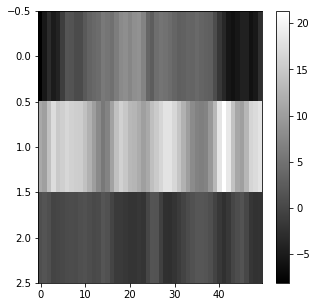

In [21]:
plt.figure(figsize = (5,5))
plt.imshow(Fa[57], interpolation='nearest', aspect='auto', cmap= 'gray')
plt.colorbar()
plt.show()
%matplotlib inline


In [22]:
Fa.shape

(6942, 3, 50, 1)

In [23]:
BUFFER_SIZE = Fa.shape[0]
BATCH_SIZE = 100
train_dataset = tf.data.Dataset.from_tensor_slices(Fa).shuffle(BATCH_SIZE)


# Discriminator Model

In [37]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(3,50,1)))
    model.add(tf.keras.layers.Conv2D(7, (3,3), padding = "same"))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dense(50, activation = 'relu'))
    model.add(tf.keras.layers.Dense(1))
    return model

In [38]:
model_discriminator = make_discriminator_model()
model_discriminator(np.random.randn(1,3,50,1).astype('float32'))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.05662378]], dtype=float32)>

In [48]:
discriminator_optimizer = tf.optimizers.Adam(1e-3)
generator_optimizer = tf.optimizers.Adam(1e-3)

In [49]:
def get_discriminator_loss(real_predictions, fake_predictions):
    real_predictions = tf.sigmoid(real_predictions)
    fake_predictions = tf.sigmoid(fake_predictions)
    real_loss = tf.losses.binary_crossentropy(tf.ones_like(real_predictions), real_predictions)
    fake_loss = tf.losses.binary_crossentropy(tf.zeros_like(fake_predictions), fake_predictions)
    return real_loss+fake_loss

# Generator

In [50]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(3*50*25, input_shape = (100,)))
    model.add(tf.keras.layers.BatchNormalization())
    print(model.output_shape)
    model.add(tf.keras.layers.Reshape((3,50,25)))
    print(model.output_shape)
    model.add(tf.keras.layers.Conv2DTranspose(128, (3,3), padding = 'same'))
    print(model.output_shape)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2DTranspose(64, (3,3),strides = (1,1), padding = 'same'))
    print(model.output_shape)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2DTranspose(1, (3,3),strides = (1,1), padding = 'same'))
    print(model.output_shape)
    return model

In [51]:
generator = make_generator_model()

(None, 3750)
(None, 3, 50, 25)
(None, 3, 50, 128)
(None, 3, 50, 64)
(None, 3, 50, 1)


In [52]:
def get_generator_loss(fake_predictions):
    fake_predictions = tf.sigmoid(fake_predictions)
    fake_loss = tf.losses.binary_crossentropy(tf.ones_like(fake_predictions), fake_predictions)
    return fake_loss
    

# Training


In [53]:
def train(dataset, epochs):
    for _ in range(epochs):
        for datum in dataset:
            datum = tf.cast(datum, tf.dtypes.float32)
            datum = tf.reshape(datum,(1,3,50,1))
            print(datum.shape)

            train_step(datum)

In [61]:
def train_step(datum):
    #fake_datum_noise = np.random.randn(BATCH_SIZE, 100).astype('float32')
    fake_datum_noise = np.random.randn(3750,100).astype('float32')
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        discriminator_optimizer = tf.optimizers.Adam(1e-3)

        generated_datum = generator(fake_datum_noise)
     
        real_output = model_discriminator(datum)

        fake_output = model_discriminator(generated_datum)
        
        gen_loss = get_generator_loss(fake_output)
        disc_loss = get_discriminator_loss(real_output, fake_output)
        
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, model_discriminator.variables)
        
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, model_discriminator.trainable_variables))
        
        print("generated loss : ", np.mean(gen_loss))
        print("discriminator loss : ", np.mean(disc_loss))
        
        

In [62]:
train_images_samples = tf.reshape(train_images_samples,(500,150,3,1))
#train_images_samples = (tf.cast(train_images_samples,dtype=tf.dtypes.float32)-127.5)/127.5
fake_images = generator(np.random.rand(500,100))

real_predictions = discriminator_model(train_images_samples)
fake_predictions = discriminator_model(fake_images)

disc_loss = get_discriminator_loss(real_predictions,fake_predictions)
disc_grad = disc_tape.gradient(disc_loss,discriminator_model.variables)

gen_loss = get_generator_loss(fake_predictions)
gen_grad = gen_tape.gradient(gen_loss,generator.variables)

discriminator_optimizer.apply_gradients(zip(disc_grad,discriminator_model.variables))
generator_optimizer.apply_gradients(zip(gen_grad,generator.variables))
print(disc_grad,discriminator_model.variables)

NameError: name 'train_images_samples' is not defined

In [63]:
train(train_dataset,5)

(1, 3, 50, 1)


InvalidArgumentError: var and grad do not have the same shape[128] [3,3,128,25] [Op:ResourceApplyAdam]

In [ ]:
!nvidia-smi

In [ ]:
!sudo kill 18962

In [ ]:
devverse